# Tutorial 8: A Joint Bayesian Inverse Problem - Inferring Surface Mass Change from Tide Gauges and GRACE Data

In this tutorial, we demonstrate the power of **joint inversions** by combining two complementary data sources: sparse tide gauge observations and global GRACE spherical harmonic coefficient data. This approach leverages the strengths of both datasets to provide improved estimates of surface mass changes.

Building on the framework established in **Tutorial 5** (tide gauge inversion for ice melt) and **Tutorial 7** (GRACE inversion for ocean thickness), we will use the direct sum capabilities from `pygeoinf` (demonstrated in **Tutorial 9** of `pygeoinf`) to create a single, unified inverse problem.

The key advantage of a joint inversion is that it allows us to:
* Combine the **high spatial resolution** information from tide gauges with the **global coverage** of GRACE data
* Obtain better constrained estimates of surface mass change
* Properly account for the different error characteristics of each dataset

Unlike the previous tutorials that focused on specific types of mass change (ice or ocean), here we infer **general surface mass change**, which simplifies our operator construction since we don't need projection operators.

## Setup

We begin by importing the necessary components from `pyslfp`, `pygeoinf`, and other standard libraries. We will also initialize our `FingerPrint` model, which provides the underlying physics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pyslfp as sl
import pygeoinf as inf
import cartopy.crs as ccrs

# Initialize the core fingerprint model - using lmax=128 for computational efficiency
fp = sl.FingerPrint(
    lmax=32,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp.set_state_from_ice_ng()

## Step 1: Loading the Tide Gauge Data

We will use the real locations from the GLOSS tide gauge network, as in Tutorial 5. These provide high-precision point measurements of sea level change.

In [2]:
# Load the full list of GLOSS tide gauge stations
names, lats, lons = sl.read_gloss_tide_gauge_data()

# --- Configuration for data selection ---
use_all_stations = True
if not use_all_stations:
    number_of_stations_to_sample = 30
    
# -----------------------------------------
if use_all_stations:
    tide_gauge_points = list(zip(lats, lons))
else:
    # Create a reproducible random sample of stations
    random.seed(123)
    indices = random.sample(range(len(names)), number_of_stations_to_sample)
    sampled_lats = [lats[i] for i in indices]
    sampled_lons = [lons[i] for i in indices]
    tide_gauge_points = list(zip(sampled_lats, sampled_lons))

print(f"Using {len(tide_gauge_points)} tide gauge stations for the joint inversion.")

ValueError: not enough values to unpack (expected 3, got 2)

## Step 2: Defining the Model Space

For this tutorial, our unknown is the global pattern of **surface mass change**. Unlike the previous tutorials, we don't restrict the solution to specific regions (ice sheets or oceans), allowing for general surface mass redistributions.

We use a `pygeoinf.symmetric_space.sphere.Sobolev` space with prescribed order and smoothness, the same approach as in the previous tutorials.

In [3]:
# Define the model space for the unknown surface mass change
order = 2.0
scale_km = 500.0
scale = scale_km * 1000 / fp.length_scale

model_space = inf.symmetric_space.sphere.Sobolev(
    fp.lmax, order, scale, radius=fp.mean_sea_floor_radius
)

## Step 3: Defining the Forward Problems

We now set up two separate forward problems that will be combined into a joint inversion:

1. **Tide Gauge Problem**: Links surface mass change to sea level observations at discrete tide gauge locations
2. **GRACE Problem**: Links surface mass change to spherical harmonic coefficient observations

Since we're working with general surface mass change (not restricted to ice or ocean), our operator chain is simplified compared to the previous tutorials - we don't need projection operators.

In [4]:
# Common operator: Maps surface mass load to the full response
fingerprint_operator = fp.as_sobolev_linear_operator(order, scale, rtol=1e-9)

# --- Problem 1: Tide Gauge Observations ---
# Evaluate at tide gauge locations - the tide gauge operator extracts sea level automatically
tide_gauge_operator = sl.operators.tide_gauge_operator(fingerprint_operator.codomain, tide_gauge_points)
forward_op_tide = tide_gauge_operator @ fingerprint_operator

# Define tide gauge measurement errors
tide_gauge_std_dev_m = 0.0005
tide_gauge_std_dev = tide_gauge_std_dev_m / fp.length_scale
tide_gauge_data_error = inf.GaussianMeasure.from_standard_deviation(
    forward_op_tide.codomain, tide_gauge_std_dev
)

# Create the tide gauge forward problem
tide_gauge_problem = inf.LinearForwardProblem(forward_op_tide, data_error_measure=tide_gauge_data_error)

# --- Problem 2: GRACE Observations ---
# Extract spherical harmonic coefficients up to degree 20
observation_degree = 10
grace_operator = sl.operators.grace_operator(fingerprint_operator.codomain, observation_degree)
forward_op_grace = grace_operator @ fingerprint_operator

# Define GRACE measurement errors
grace_std_dev_m = 0.0005
grace_std_dev = grace_std_dev_m / fp.length_scale
grace_data_error = inf.GaussianMeasure.from_standard_deviation(
    forward_op_grace.codomain, grace_std_dev
)

# Create the GRACE forward problem
grace_problem = inf.LinearForwardProblem(forward_op_grace, data_error_measure=grace_data_error)

print("Space dimensions:")
print(f"Tide gauge problem: {model_space.dim} -> {forward_op_tide.codomain.dim}")
print(f"GRACE problem: {model_space.dim} -> {forward_op_grace.codomain.dim}")

Space dimensions:
Tide gauge problem: 1089 -> 75
GRACE problem: 1089 -> 117


## Step 4: Creating the Joint Forward Problem

Using the direct sum capabilities from `pygeoinf`, we combine the two forward problems into a single joint problem. This allows us to solve for the surface mass change using both datasets simultaneously.

In [5]:
# Create the joint forward problem using direct sum
joint_problem = inf.LinearForwardProblem.from_direct_sum([tide_gauge_problem, grace_problem])

print(f"Joint problem: {model_space.dim} -> {joint_problem.forward_operator.codomain.dim}")

Joint problem: 1089 -> 192


## Step 5: Setting up the Prior and Generating Synthetic Data

We define a prior probability distribution for the surface mass change and generate synthetic data to test our joint inversion. Since we're working with general surface mass change, we use the prior directly without any masking operations.

In [6]:
# Set up the model prior measure - no projection needed for general surface mass change
pointwise_std_m = 0.1
pointwise_std = pointwise_std_m / fp.length_scale
model_prior_measure = model_space.point_value_scaled_heat_kernel_gaussian_measure(scale, pointwise_std)

# Generate synthetic ground truth and noisy data
model_true, joint_data = joint_problem.synthetic_model_and_data(model_prior_measure)

print(f"Generated synthetic data:")
print(f"  Tide gauge data: {len(joint_data[0])} observations")
print(f"  GRACE data: {len(joint_data[1])} spherical harmonic coefficients")

Generated synthetic data:
  Tide gauge data: 75 observations
  GRACE data: 117 spherical harmonic coefficients


(<Figure size 1000x800 with 1 Axes>,
 <GeoAxes: >,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7a0931bd0bd0>)

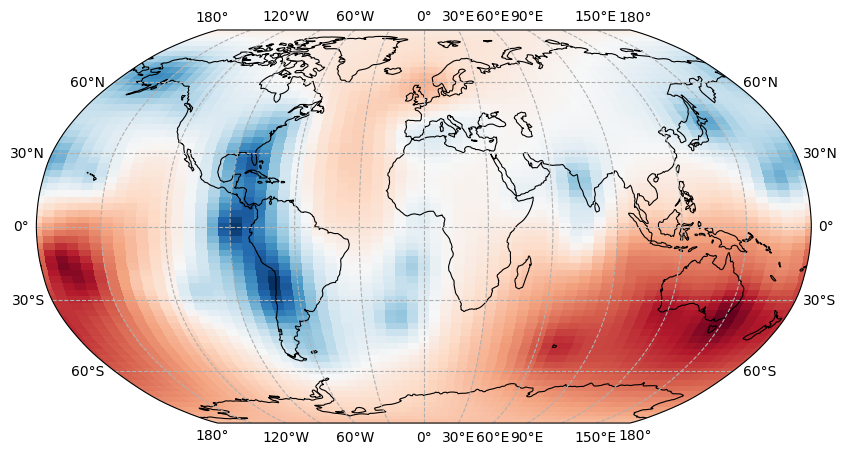

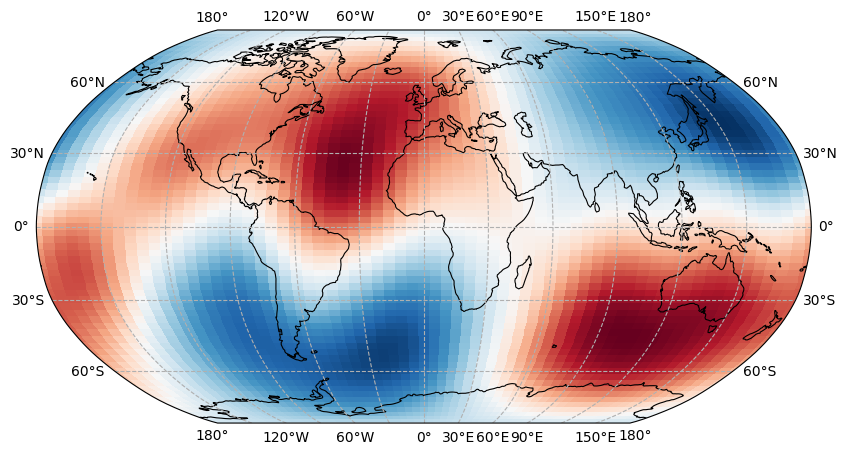

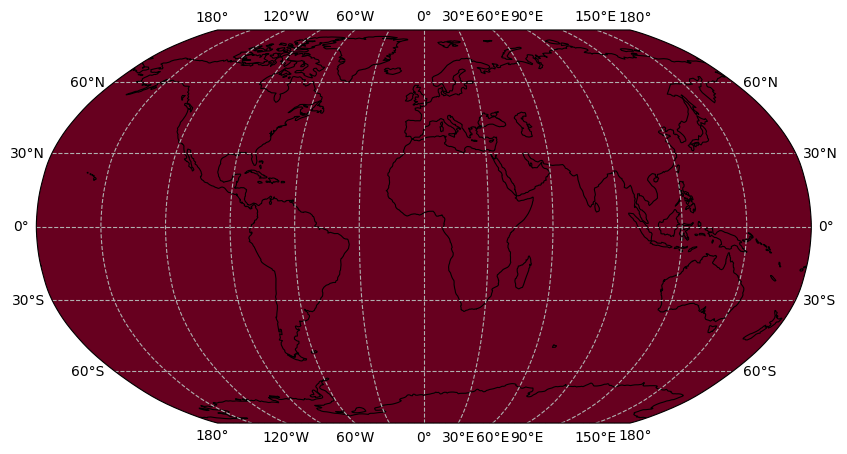

In [7]:
sl.plot(joint_problem.forward_operator.block(0,0).adjoint(joint_data[0]))
sl.plot(grace_problem.forward_operator.adjoint(joint_data[1]))
sl.plot(joint_problem.forward_operator.adjoint(joint_data))

In [25]:
joint_problem.forward_operator.block(0,0) == tide_gauge_problem.forward_operator

True

## Step 6: Setting up Preconditioning

To accelerate the iterative solution, we create a preconditioning system using a lower resolution (lmax=64) version of the joint problem, following the approach from Tutorial 7.

In [62]:
# Create the reduced-resolution system for preconditioning
lmax_precon = 64

fp_precon = sl.FingerPrint(
    lmax=lmax_precon,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp_precon.set_state_from_ice_ng()

model_space_precon = inf.symmetric_space.sphere.Sobolev(
    fp_precon.lmax, order, scale, radius=fp_precon.mean_sea_floor_radius
)

# Recreate the forward operators at lower resolution
fingerprint_operator_precon = fp_precon.as_sobolev_linear_operator(order, scale, rtol=1e-9)

# Tide gauge problem at lower resolution
tide_gauge_operator_precon = sl.operators.tide_gauge_operator(fingerprint_operator_precon.codomain, tide_gauge_points)
forward_op_tide_precon = tide_gauge_operator_precon @ fingerprint_operator_precon
tide_gauge_problem_precon = inf.LinearForwardProblem(forward_op_tide_precon, data_error_measure=tide_gauge_data_error)

# GRACE problem at lower resolution
grace_operator_precon = sl.operators.grace_operator(fingerprint_operator_precon.codomain, observation_degree)
forward_op_grace_precon = grace_operator_precon @ fingerprint_operator_precon
grace_problem_precon = inf.LinearForwardProblem(forward_op_grace_precon, data_error_measure=grace_data_error)

# Joint problem at lower resolution
joint_problem_precon = inf.LinearForwardProblem.from_direct_sum([tide_gauge_problem_precon, grace_problem_precon])

# Prior at lower resolution
model_prior_measure_precon = model_space_precon.point_value_scaled_heat_kernel_gaussian_measure(scale, pointwise_std)

## Step 7: Solving the Joint Bayesian Inverse Problem

Now we solve the joint inverse problem using the preconditioning approach. This combines information from both tide gauges and GRACE to infer the posterior distribution of surface mass change.

In [63]:
# Set up the preconditioning system
bayesian_inversion_precon = inf.LinearBayesianInversion(joint_problem_precon, model_prior_measure_precon)
normal_operator_precon = bayesian_inversion_precon.normal_operator

# Form the preconditioner using pseudo-inverse
print("Forming the preconditioner by direct inversion...")
matrix_precon = normal_operator_precon.matrix(dense=True)
inverse_matrix_precon = np.linalg.pinv(matrix_precon) 
inverse_normal_operator_precon = inf.LinearOperator.from_matrix(
    normal_operator_precon.domain,
    normal_operator_precon.codomain,
    inverse_matrix_precon
)

# Set up the full-resolution Bayesian inversion
bayesian_inversion = inf.LinearBayesianInversion(joint_problem, model_prior_measure)

# Solve for the posterior distribution
print("Solving the joint inverse problem...")
model_posterior_measure = bayesian_inversion.model_posterior_measure(
    joint_data, inf.CGMatrixSolver(), preconditioner=inverse_normal_operator_precon
)

# Get the posterior expectation
model_posterior_expectation = model_posterior_measure.expectation

print(f'Number of fingerprint solutions: {fp.solver_counter}')
print("Joint inversion completed successfully!")

Forming the preconditioner by direct inversion...
Solving the joint inverse problem...
Number of fingerprint solutions: 10
Joint inversion completed successfully!
Solving the joint inverse problem...
Number of fingerprint solutions: 10
Joint inversion completed successfully!


In [64]:
A = joint_problem.forward_operator.matrix(dense=True)
Q = model_prior_measure.covariance.matrix(dense=True)
R = joint_problem.data_error_measure.covariance.matrix(dense=True)

N = A @ Q @ A.T + R

In [65]:
N

array([[ 1.22924879e-17,  6.35021471e-18,  8.67734975e-18, ...,
         9.63588204e-20,  3.35495176e-19,  1.96666697e-19],
       [ 6.35021471e-18,  1.02340461e-17,  6.36476454e-18, ...,
         1.12691133e-19,  5.02997960e-20,  2.25229496e-19],
       [ 8.67734975e-18,  6.36476454e-18,  1.12754089e-17, ...,
        -2.14545770e-19,  1.74448918e-19,  1.40113166e-19],
       ...,
       [ 9.63588204e-20,  1.12691133e-19, -2.14545770e-19, ...,
         6.08515545e-18, -1.70265001e-20,  1.22881203e-20],
       [ 3.35495176e-19,  5.02997960e-20,  1.74448918e-19, ...,
        -1.70265001e-20,  6.10226540e-18, -7.74619285e-21],
       [ 1.96666697e-19,  2.25229496e-19,  1.40113166e-19, ...,
         1.22881203e-20, -7.74619285e-21,  6.11181816e-18]])

In [66]:
bayesian_inversion.normal_operator.matrix(dense=True)

array([[6.15920698e-21, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.15920698e-21, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.15920698e-21, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.15920698e-21, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.15920698e-21, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.15920698e-21]])

## Step 8: Analyzing and Visualizing the Results

We will now visualize the results of our joint inversion, comparing the true surface mass change with our inferred result. We'll also show the tide gauge locations to illustrate the spatial distribution of our measurements.

### Plotting the Inferred Surface Mass Change

First, we compare the "ground truth" surface mass change with our joint inversion result:

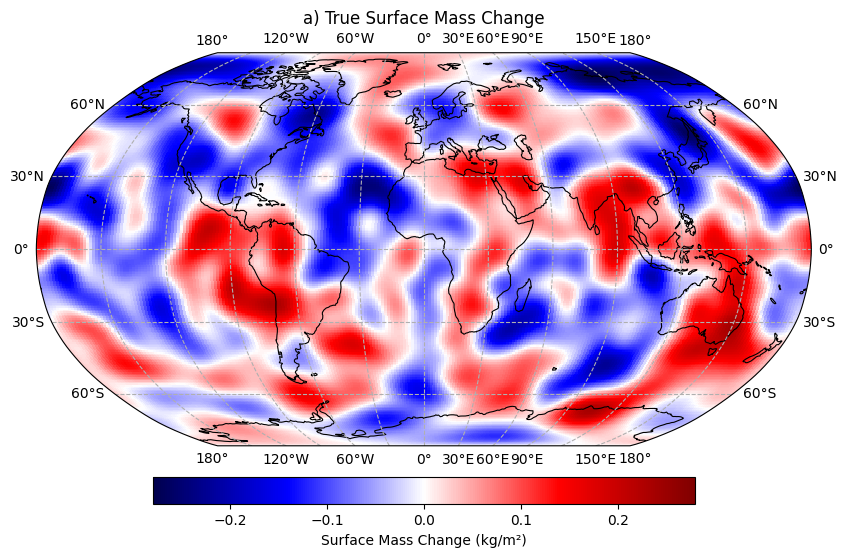

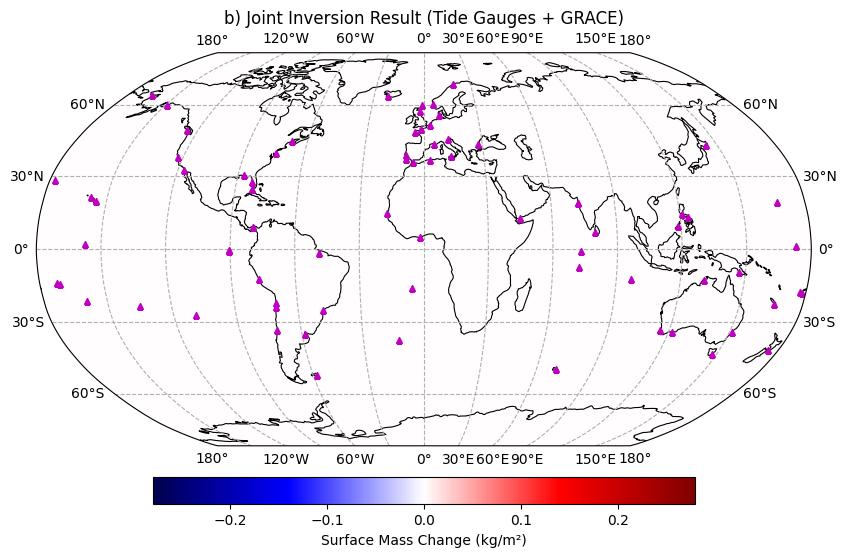

In [18]:
# Calculate a shared, symmetric color scale for the surface mass change plots
max_abs_mass_change = np.nanmax(
    np.abs(
        np.concatenate([
            (model_true).data.flatten(),
            (model_posterior_expectation).data.flatten()
        ])
    )
) * fp.length_scale

# Plot 1: The "Ground Truth" Model
fig1, ax1, im1 = sl.plot(
    model_true * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_mass_change,
    vmax=max_abs_mass_change
)
ax1.set_title("a) True Surface Mass Change")
fig1.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05, shrink=0.7, 
              label="Surface Mass Change (kg/m²)")

# Plot 2: The Joint Inversion Result
fig2, ax2, im2 = sl.plot(
    model_posterior_expectation * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_mass_change,
    vmax=max_abs_mass_change
)
ax2.set_title("b) Joint Inversion Result (Tide Gauges + GRACE)")

# Mark the tide gauge locations
tide_gauge_lats = [p[0] for p in tide_gauge_points]
tide_gauge_lons = [p[1] for p in tide_gauge_points]
ax2.plot(tide_gauge_lons, tide_gauge_lats, 'm^', markersize=4, 
         transform=ccrs.PlateCarree(), label='Tide Gauges')

fig2.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.05, shrink=0.7, 
              label="Surface Mass Change (kg/m²)")
plt.show()

### Plotting the Predicted Sea Level Fingerprint

As a consistency check, we can predict the sea level fingerprint from our inferred surface mass change and compare it to the true fingerprint:

In [14]:
# Calculate sea level fields from both the true and inferred mass changes
sea_level_projection = fingerprint_operator.codomain.subspace_projection(0)
sea_level_true = sea_level_projection @ fingerprint_operator @ model_true
sea_level_posterior = sea_level_projection @ fingerprint_operator @ model_posterior_expectation

# Apply ocean mask for visualization
ocean_mask = fp.ocean_projection()
max_abs_sl_change = np.nanmax(
    np.abs(
        np.concatenate([
            (sea_level_true * ocean_mask).data.flatten(),
            (sea_level_posterior * ocean_mask).data.flatten()
        ])
    )
) * fp.length_scale

# Plot 3: The "True" Sea-Level Field
fig3, ax3, im3 = sl.plot(
    sea_level_true * ocean_mask * fp.length_scale,    
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax3.set_title("c) True Sea-Level Fingerprint")
ax3.plot(tide_gauge_lons, tide_gauge_lats, 'm^', markersize=4, 
         transform=ccrs.PlateCarree())
fig3.colorbar(im3, ax=ax3, orientation="horizontal", pad=0.05, shrink=0.7, 
              label="Sea Level Change (m)")

# Plot 4: The Sea-Level Field Predicted by the Joint Inversion
fig4, ax4, im4 = sl.plot(
    sea_level_posterior * ocean_mask * fp.length_scale,
    coasts=True,
    cmap="seismic",
    vmin=-max_abs_sl_change,
    vmax=max_abs_sl_change
)
ax4.set_title("d) Predicted Sea-Level Fingerprint (Joint Inversion)")
ax4.plot(tide_gauge_lons, tide_gauge_lats, 'm^', markersize=4, 
         transform=ccrs.PlateCarree())
fig4.colorbar(im4, ax=ax4, orientation="horizontal", pad=0.05, shrink=0.7, 
              label="Sea Level Change (m)")
plt.show()

AttributeError: 'DHRealGrid' object has no attribute 'domain'

## Step 9: Quantifying Global Mean Sea Level Change

Finally, we demonstrate how the joint inversion can be used to quantify global mean sea level (GMSL) change with uncertainties, following the approach from Tutorial 5.

In [ ]:
# Set up the weighting function for GMSL estimates
# Note the length scale factor to dimensionalize the result
GMSL_weighting_function = -fp.one_function * fp.length_scale / (fp.water_density * fp.ocean_area)

# Form the mapping to GMSL
B = sl.averaging_operator(model_space, [GMSL_weighting_function])

# Get the true GMSL
GMSL_true = B(model_true)

# Push forward the posterior to the GMSL space
GMSL_posterior_measure = model_posterior_measure.affine_mapping(operator=B)

# Get the measure as a scipy distribution
GMSL_distribution = GMSL_posterior_measure.as_multivariate_normal()

# Plot the PDF for GMSL
gmsl_mean = GMSL_distribution.mean[0]
gmsl_std = np.sqrt(GMSL_distribution.cov[0, 0])
x_max = np.max([np.abs(gmsl_mean - 6 * gmsl_std), np.abs(gmsl_mean + 6 * gmsl_std)])
x_axis = np.linspace(-x_max, x_max, 1000)
pdf_values = GMSL_distribution.pdf(x_axis)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, pdf_values, color='blue', lw=2, label='Joint Inversion PDF')
plt.fill_between(x_axis, pdf_values, color='blue', alpha=0.2)
plt.axvline(gmsl_mean, color='red', linestyle='--', lw=2, 
           label=f'Estimated Mean: {gmsl_mean:.5f} m')
plt.axvline(GMSL_true[0], color='black', linestyle='-', lw=2, 
           label=f'True Value: {GMSL_true[0]:.5f} m')
plt.title('Probability Distribution of GMSL Change (Joint Inversion)', fontsize=14)
plt.xlabel('GMSL Change (m)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"GMSL Results:")
print(f"  True value: {GMSL_true[0]:.6f} m")
print(f"  Joint inversion mean: {gmsl_mean:.6f} m")
print(f"  Joint inversion std: {gmsl_std:.6f} m")
print(f"  Error: {abs(gmsl_mean - GMSL_true[0]):.6f} m")

## Conclusion

In this tutorial, we have successfully demonstrated a **joint Bayesian inversion** that combines tide gauge and GRACE data to infer global surface mass changes. The key achievements include:

* **Joint Problem Formulation**: We showed how to combine two different types of observations (sparse tide gauge measurements and global GRACE coefficients) into a single, unified inverse problem using the direct sum framework from `pygeoinf`.

* **Computational Efficiency**: We implemented an effective preconditioning strategy using a lower-resolution problem to accelerate the iterative solution of the full joint system.

* **Comprehensive Analysis**: The joint inversion successfully recovered the large-scale features of the true surface mass change pattern, with the predicted sea level fingerprint closely matching the true fingerprint.

* **Uncertainty Quantification**: We demonstrated how to extract meaningful quantities like global mean sea level change with proper uncertainty estimates from the full posterior distribution.

The joint approach offers several advantages over individual inversions:
- **Improved Spatial Resolution**: Tide gauges provide high-precision point constraints that help resolve regional features
- **Global Coverage**: GRACE data ensures that the inversion is informed by global observations
- **Consistent Framework**: Both datasets are processed within a single, physically consistent framework
- **Proper Error Propagation**: Different error characteristics of each dataset are properly accounted for

This methodology provides a foundation for more complex real-world applications involving multiple Earth observation datasets and represents a powerful approach for understanding global mass redistributions and their impact on sea level change.